# Lab3. Topic modeling

## Melnikov, Malysheva, Selivanovskaya

In [1]:
!pip install pyLDAvis

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136900 sha256=d59cf384b77e630cf003c0160b945e13973c19129cbe6619afaf40186e070107
  Stored in directory: c:\users\admin\appdata\local\pip\cache\wheels\c9\21\f6\17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491059 sha256=3674f60a6f0417beb36a3d76aa1c18237c38c7260dae63f16a2c870cb67350b2
  Stored in directory: c:\users\admin\appdata\local\pip\cache\wheels\56\b0\fe\4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully 

You should consider upgrading via the 'C:\Users\admin\pr1\Scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import pymorphy2
from scipy.sparse import *
import stop_words
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.stem.snowball import RussianStemmer
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.notebook import tqdm
import pyLDAvis
from gensim.models import CoherenceModel
import pyLDAvis.gensim_models as gensimvis
import re
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
c:\users\admin\pr1\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


### Load prepocessed data and concatenate it

In [3]:
# Evgeny's data
df1 = pd.read_json("Preprocessed_data1.json")
df1

article_id  \
0     https://www.nn.ru/text/transport/2022/01/30/70...   
1     https://www.nn.ru/text/transport/2022/01/29/70...   
2     https://www.nn.ru/text/transport/2022/01/26/70...   
3     https://www.nn.ru/text/gorod/2022/01/25/70399832/   
4     https://www.nn.ru/text/transport/2022/01/24/70...   
...                                                 ...   
3995  https://www.nn.ru/text/incidents/2020/06/13/69...   
3996  https://www.nn.ru/text/incidents/2020/06/13/69...   
3997  https://www.nn.ru/text/incidents/2020/06/13/69...   
3998  https://www.nn.ru/text/incidents/2020/06/10/69...   
3999  https://www.nn.ru/text/incidents/2020/06/10/69...   

                                                  title   category  \
0     Пятый мост через Оку начнут строить уже в этом...  transport   
1     «Решение о строительстве метро на площади Своб...  transport   
2     Более 440 автомобилей, мешающих уборке снега, ...  transport   
3     Улицу Горького частично перекроют для строител...  transport   
4     (Не) передавайте за проезд, пожалуйста: почти ...  transport   
...                                                 ...        ...   
3995           В лобовом ДТП под Балахной погиб ребенок  incidents   
3996  Под Балахной лоб в лоб столкнулись два автомоб...  incidents   
3997  Красный Cadillac перевернулся на Гребном канал...  incidents   
3998  Из-за смертельной аварии, которую устроил актё...  incidents   
3999  В Автозаводском районе произошло ДТП со скорой...  incidents   

                                                   tags  \
0                       [мост, новая транспортная сеть]   
1       [метро, строительство метро в Нижнем Новгороде]   
2                            [уборка снега, эвакуаторы]   
3       [метро, строительство метро в Нижнем Новгороде]   
4     [Нижний Новгород, валидатор, транспорт, общест...   
...                                                 ...   
3995                   [ДТП с погибшими, погиб ребенок]   
3996                          [ДТП с погибшими, авария]   
3997                          [ДТП, авария, пьяное ДТП]   
3998                              [ДТП, Михаил Ефремов]   
3999                       [ДТП, ДТП со скорой помощью]   

                                                   text  
0     новый мост ока начать строить год контракт раз...  
1     мку гуммид ответить урбанист настаивать строит...  
2     автомобиль мешать уборка снег нижний новгород ...  
3     март начаться первый перекрытие улица нижний н...  
4     общественный транспорт нижний новгород заработ...  
...                                                 ...  
3995  плохой новость сегодня заканчиваться сожаление...  
3996  третий страшный дтп сегодняшний суть произойти...  
3997  сегодня нижний новгород водитель cadillac отпр...  
3998  полиция москва возбудить ещё один уголовный де...  
3999  сегодня вечером автозаводский район нижний нов...  

[4000 rows x 5 columns]

In [4]:
# Katya's data
df2 = pd.read_json("Preprocessed_data2.json")
df2

article_id  \
0              https://lenta.ru/news/2022/01/19/sosad/   
1     https://lenta.ru/news/2022/01/18/opyatetivyshki/   
2               https://lenta.ru/news/2022/01/18/maid/   
3         https://lenta.ru/news/2022/01/18/kakpochemu/   
4        https://lenta.ru/news/2022/01/18/podorozhali/   
...                                                ...   
5076         https://lenta.ru/news/2018/08/29/obideli/   
5077       https://lenta.ru/news/2018/08/25/edro_meme/   
5078      https://lenta.ru/news/2018/08/25/joejoe_rip/   
5079      https://lenta.ru/news/2018/08/25/binoculars/   
5080       https://lenta.ru/news/2018/08/25/otrajenie/   

                                                  title      category  \
0     Россиянка назвала главные ошибки при покупке э...  travel/world   
1         Раскрыто опасное влияние вышек 5G на полеты    travel/world   
2         Названы самые грязные вещи в номерах отелей    travel/world   
3     Названа причина экстренной посадки пассажирско...  travel/world   
4     Стало известно о значительном подорожании загр...  travel/world   
...                                                 ...           ...   
5076  Рэпер 50 Cent обиделся на мем и пожелал его ав...   media/memes   
5077         В сети призвали вернуть кокаин депутатам     media/memes   
5078       Умерла самая известная на планете капибара     media/memes   
5079                       Меркель сочли вуайеристкой     media/memes   
5080  Живущее своей жизнью отражение в зеркале напуг...   media/memes   

              tags                                               text  
0      путешествие  россиянка отдохнуть египет назвать плохой экск...  
1      путешествие  крупный американский авиакомпания раскрыть опа...  
2      путешествие  горничная эллиана мадрид elliana madrid работа...  
3      путешествие  нарушение система управление назвать предварит...  
4      путешествие  исполнительный директор ассоциация туроператор...  
...            ...                                                ...  
5076  интернет сми  рэп исполнитель cent пожелать смерть автор мем...  
5077  интернет сми  сеть воодушевление отреагировать новость обнар...  
5078  интернет сми  скончаться капибара джоджо благодаря свой друж...  
5079  интернет сми  соцсеть отреагировать решение канцлер фрг анге...  
5080  интернет сми  пользователь twitter ник jolynn опубликовать с...  

[5081 rows x 5 columns]

In [5]:
# Dasha's data
df3 = pd.read_json("Preprocessed_data3.json", lines=True)

for i in range(df3.shape[0]):
    df3['text'][i] = ' '.join(df3['text'][i])
    
df3 = df3.reindex(columns = df2.columns)
df3

article_id                                              title  \
0            NaN  Депутат Госдумы предложил запретить продажу ал...   
1            NaN  Экономист Ходжа объяснил, как спрогнозировать ...   
2            NaN  Что будет с рублем, нефтью и биржей на следующ...   
3            NaN  В Норвегии признали суперфудом "ненавистную го...   
4            NaN  В Минцифры объяснили, как не стать жертвой мош...   
...          ...                                                ...   
5012         NaN  Президент Молдавии объяснила, почему не приеде...   
5013         NaN    Кличко по ошибке поздравил киевлян с 2222 годом   
5014         NaN  Тату-салоны Европы готовятся к новым запретам ...   
5015         NaN     В Японии запустили первый в мире автобус-поезд   
5016         NaN  Турции удалось снизить курс доллара нестандарт...   

       category                                               tags  \
0     ekonomika  Товары и цены, Торговля, Госдума, Алкоголь и т...   
1     ekonomika                            Финансы, Валютный рынок   
2     ekonomika  Отрасли, Нефть и газ, Финансы, Валютный рынок,...   
3     ekonomika                 Европа, Норвегия, Отрасли, Ресурсы   
4     ekonomika                                                      
...         ...                                                ...   
5012        mir                                 экс-СССР, Молдавия   
5013        mir                                  экс-СССР, Украина   
5014        mir                                             Европа   
5015        mir                   Восточная Азия, Япония, РГ-Видео   
5016        mir    Финансы, Валютный рынок, Ближний Восток, Турция   

                                                   text  
0     выходной день весь россия должный действовать ...  
1     эксперт кафедра экономический теория имя плеха...  
2     михаил васильев главный аналитик ожидать предс...  
3     норвегия изучение качество рыба местный река п...  
4     курс повод новый схема мошенничество связанный...  
...                                                 ...  
5012  мэр киев виталий поздравлять киевлянин новый г...  
5013  большинство вещество входящий чернила использо...  
5014  город японский префектура остров сикоку запуст...  
5015  президент сша джозеф декабрь подписать оборонн...  
5016  греция январь вводиться ряд новый ограничитель...  

[5017 rows x 5 columns]

In [6]:
# concatenate all the datasets
df = df1.append(df2, ignore_index = True)
df = df.append(df3, ignore_index=True)

# tokenize words
texts = []
for i in range(df.shape[0]):
    texts.append(df['text'][i].split())


Here, we find the list of all unique categories

In [7]:
categories_w_sub = df.category.unique() # categories with sub categories (e. g. )
categories = categories_w_sub.copy()
for i in range(len(categories)):
    categories[i] = re.sub(r'/.*',"", categories[i])
categories = np.unique(categories)
categories = np.delete(categories, np.where(categories == 'mir')) # we remove mir since mir and world are the same category
categories

array(['auto', 'bezopasnost', 'ekonomika', 'health', 'incidents',
       'kultura', 'media', 'science', 'sport', 'style', 'transport',
       'travel', 'world'], dtype=object)

###  Compute bigrams and add them to each text

In [8]:
from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(texts, min_count=20)
for idx in range(len(texts)):
    for token in bigram[texts[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            texts[idx].append(token)

###  Create a dictionary and remove rare and common words

In [11]:
from gensim.corpora import Dictionary
dictionary = Dictionary(texts)
print(f"Dictionary length before filtering {len(dictionary)}")

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)

print(f"Dictionary length after filtering {len(dictionary)}")

Dictionary length before filtering 71848
Dictionary length after filtering 12818


In [12]:
temp = dictionary[0]  # This is only to "load" the dictionary.
dictionary.id2token

{0: 'автобус',
 1: 'автовокзал',
 2: 'автозаводский',
 3: 'автозаводский_район',
 4: 'автомобиль',
 5: 'бесплатный',
 6: 'богородский',
 7: 'будущий',
 8: 'быть',
 9: 'включать',
 10: 'включить',
 11: 'владимир',
 12: 'владимир_путин',
 13: 'волга',
 14: 'волновать',
 15: 'впервые',
 16: 'встреча',
 17: 'второй',
 18: 'второй_половина',
 19: 'выбрать',
 20: 'выделить',
 21: 'гагарин',
 22: 'глеб',
 23: 'глеб_никитин',
 24: 'год',
 25: 'губернатор',
 26: 'далее',
 27: 'движение',
 28: 'действовать',
 29: 'документация',
 30: 'должный',
 31: 'дорога',
 32: 'дублёр',
 33: 'ездить',
 34: 'заключить',
 35: 'замгубернатор',
 36: 'заместитель',
 37: 'заместитель_губернатор',
 38: 'заниматься',
 39: 'идея',
 40: 'именно',
 41: 'иметь',
 42: 'институт',
 43: 'интенсивность',
 44: 'информация',
 45: 'инфраструктурный',
 46: 'км',
 47: 'компания',
 48: 'комплексный',
 49: 'конец',
 50: 'конец_май',
 51: 'контракт',
 52: 'который',
 53: 'май',
 54: 'маршрутный',
 55: 'маршрутный_сеть',
 56: 'меню'

###  Vectorize the texts

In [13]:
corpus = [dictionary.doc2bow(text) for text in texts]
print(f"The total number of texts is {len(corpus)}")

The total number of texts is 14098


In [14]:
corpus

[[(0, 1),
  (1, 1),
  (2, 3),
  (3, 2),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 2),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 2),
  (22, 1),
  (23, 1),
  (24, 6),
  (25, 2),
  (26, 1),
  (27, 2),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 2),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 2),
  (43, 1),
  (44, 3),
  (45, 1),
  (46, 1),
  (47, 2),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 2),
  (52, 2),
  (53, 1),
  (54, 3),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 1),
  (59, 2),
  (60, 8),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 1),
  (67, 1),
  (68, 2),
  (69, 2),
  (70, 1),
  (71, 2),
  (72, 6),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 3),
  (78, 1),
  (79, 2),
  (80, 1),
  (81, 1),
  (82, 1),
  (83, 1),
  (84, 1),
  (85, 1),
  (86, 1),
  (87, 2),
  (88, 1),
  (89, 1),
  (90, 1),
  (91, 1)

### Train LDA model

Some helpful functions that will be used later:

In [156]:
def print_coherence(model, texts, dictionary):
    coherence_score_lda = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_score_lda.get_coherence()
    print('Coherence Score:', coherence_score)

In [157]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

def plot_worldclouds(lda_model, ncols, nrows):
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
    
    cloud = WordCloud(#stopwords=stop_words,
                      background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      #colormap='tab10',
                      #color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)

    topics = lda_model.show_topics(formatted=False, num_topics=100)
    fig, axes = plt.subplots(nrows, ncols, figsize=(15,15), sharex=True, sharey=True)

    for i, ax in enumerate(axes.flatten()):
        if i < len(topics): # list index out of range fix 
            fig.add_subplot(ax)
            topic_words = dict(topics[i][1])
            cloud.generate_from_frequencies(topic_words, max_font_size=300)
            plt.gca().imshow(cloud)
            plt.gca().set_title('Topic ' + str(i + 1), fontdict=dict(size=16))
            plt.gca().axis('off')

        else:
            fig.delaxes(ax) # when there are more subplots then topics, we just remove the extra subplots
            
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()  

Here is the list of unique categories in our dataset:

In [159]:
categories, categories.shape

(array(['auto', 'bezopasnost', 'ekonomika', 'health', 'incidents',
        'kultura', 'media', 'science', 'sport', 'style', 'transport',
        'travel', 'world'], dtype=object),
 (13,))

Since there are 13 unique categories, the number of topics in the LDA model will be set to 13

In [165]:
from gensim.models import LdaModel

# Set training parameters.
num_topics = 13 # number of desired topics
chunksize = 2000 # number documents that are processed at a time in the training algorithm
passes = 40 # how often we train the model on the entire corpus (the same as epochs)
iterations = 400  # how often we repeat a particular loop over each document
eval_every = None  # Don't evaluate model perplexity, takes too much time

# Make a index to word dictionary.
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every,
    random_state=42
)

Let's take a look at the topics that our model has managed to generate:

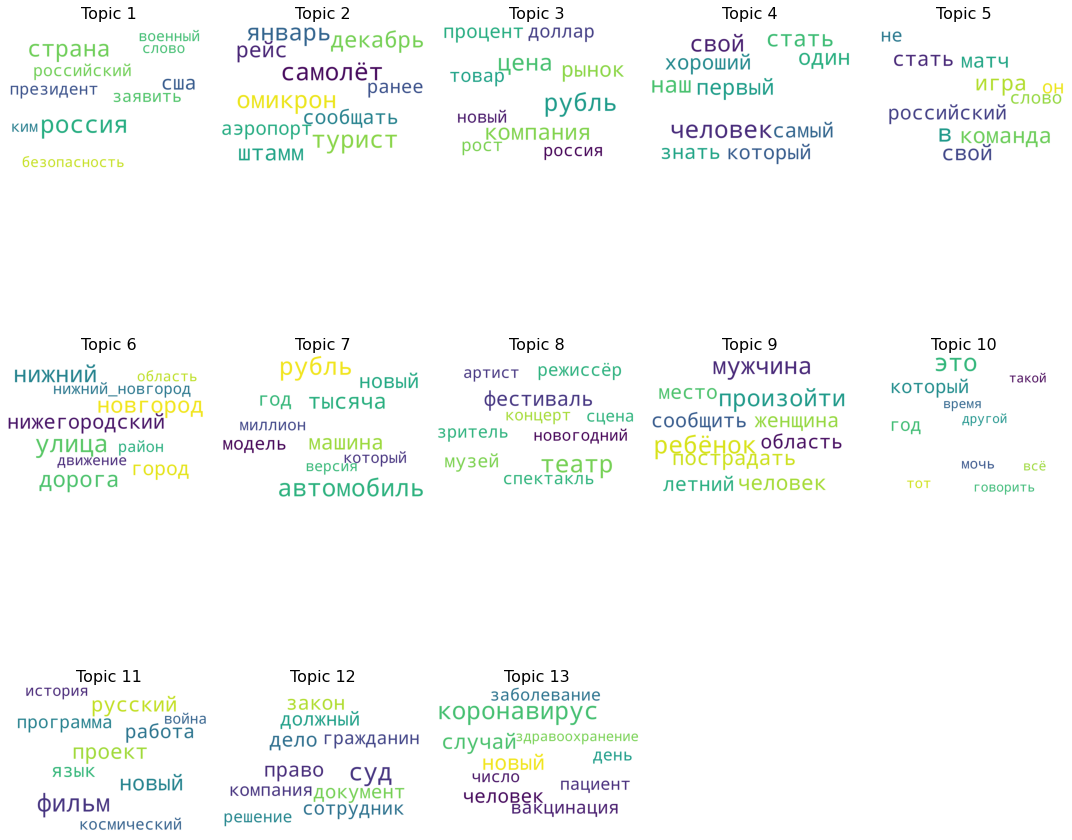

In [166]:
plot_worldclouds(model, 5, 3)

Here we can see the topics correspondig to the following known categories: 'auto' (topic 7), 'ekonomika' (topic 3), 'health' (topics 2, 13), 'incidents' (topic 9), 'kultura'/'media' (topics 8, 11), 'sport' (topic 5), 'transport' (topics 6 and 2), 'travel' (topic 2), 'world' (topic 1)

Unfortunately, the model hasn't managed to clearly define topics 4 and 10

Let's evaluate model's Coherence score

In [168]:
print_coherence(model=model, texts=texts, dictionary=dictionary)

Coherence Score: 0.556904535845379


Let's visualize the topics:

In [169]:
lda_visualization = gensimvis.prepare(model, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_visualization)

We can see that there are overlapping topics. Most notably, topic 3 is completely included in topic 10 and topic 7 is almost completely included in topic 4. 

Let's try other numbers of topics: 

In [189]:
from gensim.models import LdaModel

# Set training parameters.
nums_topics = [9, 13, 17, 21, 25] # numbers of desired topics
chunksize = 2000 # number documents that are processed at a time in the training algorithm
passes = 40 # how often we train the model on the entire corpus (the same as epochs)
iterations = 400  # how often we repeat a particular loop over each document
eval_every = None  # Don't evaluate model perplexity, takes too much time

# Make a index to word dictionary.
id2word = dictionary.id2token

best_coherence = 0
for num_topics in nums_topics:
    print(f"Fitting for {num_topics} target topics")
    model = LdaModel(
        corpus=corpus,
        id2word=id2word,
        chunksize=chunksize,
        alpha='auto',
        eta='auto',
        iterations=iterations,
        num_topics=num_topics,
        passes=passes,
        eval_every=eval_every,
        random_state=43
    )
    
    coherence_score_lda = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_score_lda.get_coherence()
    if coherence_score > best_coherence:
        best_coherence = coherence_score
        best_lda_model = model
    print(f"Coherence score {coherence_score}")
    

Fitting for 9 target topics
Coherence score 0.5327301995794514
Fitting for 13 target topics
Coherence score 0.5265000444106218
Fitting for 17 target topics
Coherence score 0.5468181944087859
Fitting for 21 target topics
Coherence score 0.5527008724484621
Fitting for 25 target topics
Coherence score 0.5375521043940534


The best score was achieved for 21 target topics

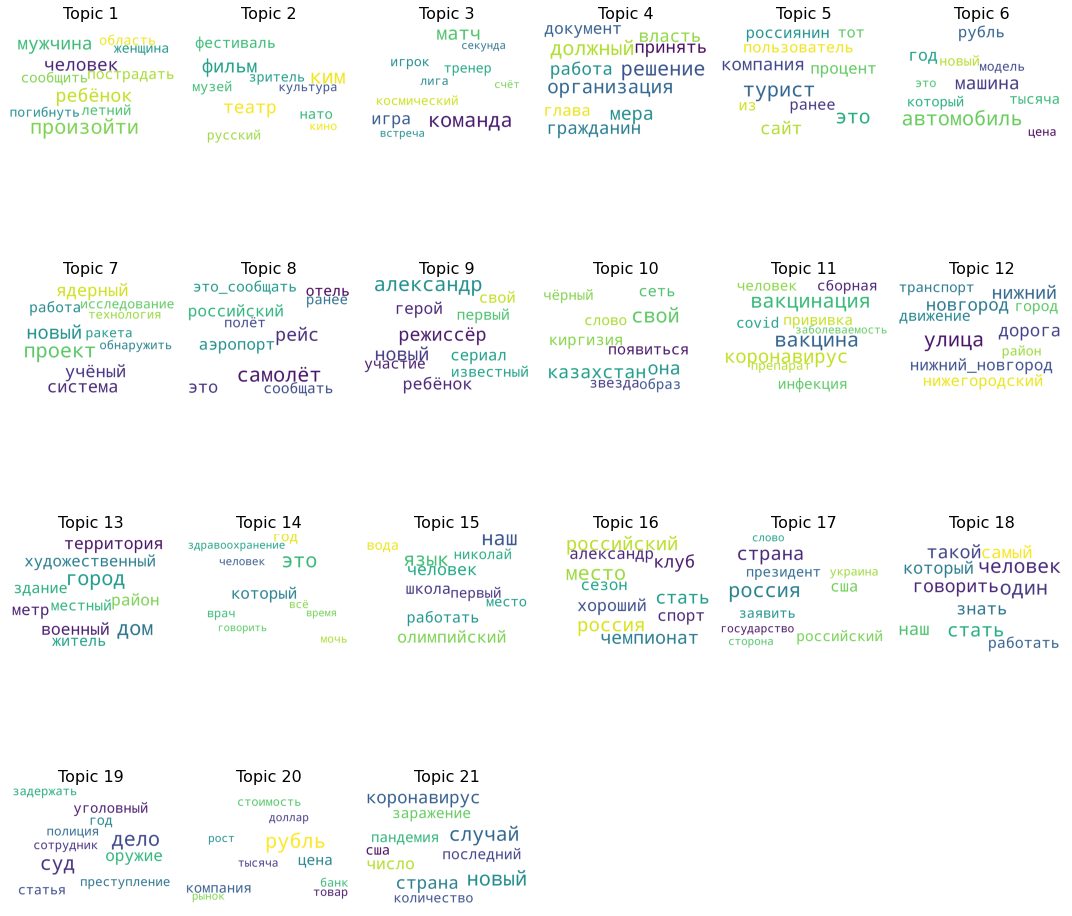

In [190]:
plot_worldclouds(best_lda_model, 6, 4)

In [191]:
lda_visualization = gensimvis.prepare(best_lda_model, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_visualization)

### Train PLSA model

In [16]:
from plsa import Corpus, Pipeline, Visualize
from plsa.pipeline import DEFAULT_PIPELINE
from plsa.algorithms import PLSA

In [17]:
n_topics = 13 #choose the number of topics

In [64]:
from typing import Iterable, Dict, Tuple
from collections import defaultdict
from numpy import zeros, ndarray, log, sign, abs

pipeline = Pipeline(*DEFAULT_PIPELINE)

class Corpus:
    def __init__(self, corpus: Iterable[str],  pipeline: Pipeline) -> None:
        self.__pipeline = pipeline
        self.__raw = []
        self.__index = defaultdict(lambda: len(self.__index))
        self.__vocabulary = {}
        self.__n_occurrences = 0
        self.__n_docs = 0
        self.__n_words = 0
        self.__doc_word = None

    def __repr__(self):
        title = self.__class__.__name__
        header = f'{title}:\n'
        divider = '=' * len(title) + '\n'
        n_docs = f'Number of documents: {self.n_docs}\n'
        n_words = f'Number of words:     {self.n_words}'
        return header + divider + n_docs + n_words
    
    def get_doc_word(self, tf_idf: bool) -> ndarray:
        if tf_idf:
            not_normalized = self.__doc_word * self.idf
            return not_normalized / not_normalized.sum()
        return self.__doc_word / self.__n_occurrences
    
    @property
    def idf(self) -> ndarray:
        """Logarithm of inverse fraction of documents each word occurs in."""
        return log(self.__n_docs / (self.__doc_word > 0.0).sum(axis=0))
    
    def get_doc_word(self, tf_idf: bool) -> ndarray:
        if tf_idf:
            not_normalized = self.__doc_word * self.idf
            return not_normalized / not_normalized.sum()
        return self.__doc_word / self.__n_occurrences

In [68]:
crp = Corpus(corpus, pipeline)
crp.n_docs = len(corpus)
crp.n_words = len(dictionary)
print(crp)

Corpus:
Number of documents: 14098
Number of words:     12818


In [69]:
plsa = PLSA(crp, n_topics, True)
plsa

TypeError: '>' not supported between instances of 'NoneType' and 'float'